In [1]:
# %pip install -q hillclimbers

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import plot_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import optuna
from optuna.samplers import TPESampler
from tqdm import tqdm
# from hillclimbers import climb_hill, partial
import shap

import warnings
warnings.filterwarnings('ignore')

In [4]:
# merge original dataset
# train_df = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
# X_test = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')
# original_df = pd.read_csv('/kaggle/input/ps4e9-original-data-loan-approval-prediction/credit_risk_dataset.csv')
# train_df = pd.concat([train_df, original_df], axis=0)
# X_test_index = X_test['id']

# merge original dataset
train_df = pd.read_csv("../data/train.csv")
X_test = pd.read_csv("../data/test.csv")
original_df = pd.read_csv("../data/original.csv")
train_df = pd.concat([train_df, original_df], axis=0)
X_test_index = X_test['id']

In [5]:
categorical_columns = train_df.select_dtypes(include=['object']).columns.to_list()

# Remove 'loan_status' from the list
if 'loan_status' in categorical_columns:  
    categorical_columns.remove('loan_status')

print(categorical_columns) 

['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']


In [6]:
numerical_columns = train_df.select_dtypes(include=['int', 'float']).columns.to_list()

for column in ['id', 'loan_status']:
    if column in numerical_columns:
        numerical_columns.remove(column)
    
print(numerical_columns)

['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']


## 1 Data Preprocessing

### 1.1 Drop unique identifier (`id` column)

In [7]:
train_df = train_df.drop(columns=['id'])
X_test = X_test.drop(columns=['id'])

### 1.2 Drop rows with missing values

In [8]:
# Drop rows with missing values in 'person_emp_length' and 'loan_int_rate'
train_df = train_df.dropna(subset=['person_emp_length', 'loan_int_rate'])

In [9]:
print(f'Shape of train set after dropping missing values: {train_df.shape}')

Shape of train set after dropping missing values: (87283, 12)


In [10]:
# double check for missing value
train_df.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

### 1.3 Drop rows with outliers

In [11]:
def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []

    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1

        # outlier step
        outlier_step = 1.5 * IQR

        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index

        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)

    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)

    return multiple_outliers


# params dataset, number of outliers for rejection, list of features
outliers_to_drop = detect_outliers(train_df, 1, numerical_columns)

In [12]:
print(f'There are {len(outliers_to_drop)} rows of outliers in the train set')

There are 3881 rows of outliers in the train set


In [13]:
print(f'Shape of train set before dropping outliers: {train_df.shape}')
train_df = train_df.drop(outliers_to_drop, axis=0).reset_index(drop=True)

Shape of train set before dropping outliers: (87283, 12)


In [14]:
print(f'Shape of train set after dropping outliers: {train_df.shape}')

Shape of train set after dropping outliers: (80636, 12)


In [15]:
# import matplotlib.pyplot as plt
# for col in numerical_columns:
#     plt.figure(figsize=(8, 4))
#     sns.histplot(train_df[col], kde=True, color='blue', label='Train')
#     sns.histplot(X_test[col], kde=True, color='orange', label='Test')
#     plt.title(f'Distribution of {col}')
#     plt.show()

### 1.4 Split features with target

In [16]:
X_train = train_df.drop(columns=['loan_status'])
y_train = train_df['loan_status']

In [17]:
if X_train.shape[0] == y_train.shape[0]:
    print(True)

True


### 1.5 Encoding categorical features

In [18]:
def one_hot_encode(df, features):
    """
    This function takes a DataFrame, identifies non-numeric (categorical) columns,
    applies one-hot encoding to them, and returns the modified DataFrame.
    """
    for col in features:
        df_dum = pd.get_dummies(df[col], prefix=col, dtype=int)
        df = df.drop(col, axis=1)
        df = pd.concat([df, df_dum], axis=1)
    return df


X_train = one_hot_encode(X_train, categorical_columns)
X_test = one_hot_encode(X_test, categorical_columns)

### 1.6 Scaling Numerical Features before doing PCA

In [19]:
scaler = StandardScaler() 

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 2 Feature Engineering

### 2.1 Generate new features

In [20]:
def feature_generation(df_):
    df = df_.copy()
    df['interest_percent_income'] = round(df['loan_int_rate'] * df['loan_amnt'] / df['person_income'], 2)
    df['zero_repayment_risk'] = np.where(df['loan_percent_income'] == 0, 1, 0)
    # Calculate repayment_year normally for non-zero loan_percent_income
    df['repayment_year'] = np.where(
        df['loan_percent_income'] != 0,
        df['loan_amnt'] / (df['loan_percent_income'] * df['person_income']),
        np.nan  # Temporarily assign NaN for zero loan_percent_income
    )
    
    # Calculate the 99th percentile of repayment_year for non-zero cases
    high_quantile_value = df['repayment_year'].quantile(0.99)
    
    # Assign the high quantile value to repayment_year for cases with zero loan_percent_income
    df['repayment_year'].fillna(high_quantile_value, inplace=True)
    df['loan_to_income'] = df['loan_amnt'] / df['person_income']

    return df

X_train = feature_generation(X_train)
X_test = feature_generation(X_test)

In [21]:
X_train.shape

(80636, 30)

In [22]:
if X_train.shape[1] == X_test.shape[1]:
    print('data validation done: train set and test set are consistent')
else:
    print('train set and test set are not consistent!')

data validation done: train set and test set are consistent


### 2.2 Balance the dataset

Common ways to handle imbalanced dataset:
1. Random under-sampling
2. Random over-sampling
3. Synthetic over-sampling: SMOTE

The method I choose here is SMOTE. I don't go with under-sampling because we don't have very large training set so I don't want to miss more information. Oversampling won't have this problem but it may suffer from overfitting.

In [23]:
from imblearn.over_sampling import SMOTE, RandomOverSampler

sm = SMOTE(sampling_strategy=1, random_state=42, k_neighbors=3)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [24]:
X = X_res.copy()
y = y_res.copy()

In [25]:
y.value_counts()

loan_status
0    67460
1    67460
Name: count, dtype: int64

In [26]:
X.shape

(134920, 30)

### 2.3 PCA 

In [27]:
# from sklearn.decomposition import PCA


# PCA_TR = PCA(n_components=15)
# X_train_scaled = PCA_TR.fit_transform(X_train_scaled)

# sum(PCA_TR.explained_variance_ratio_)

### 2.4 SelectKBest

In [28]:
# from sklearn.feature_selection import mutual_info_classif
# from sklearn.feature_selection import SelectKBest

# # select top 2 features using mutual_info_classif
# selector = SelectKBest(mutual_info_classif, k=15)
# X_new = selector.fit_transform(X, y)

# selected_features = selector.get_support(indices=True)
# feature_names = X.columns[selected_features]  # Assuming X is a DataFrame with column names

# print("Selected Features:")
# print(feature_names)

# numerical_columns = [col for col in numerical_columns if col in selected_features]


In [29]:
# X = X[feature_names]
# X_test = X_test[feature_names]

In [30]:
# X.shape, X_test.shape

## 3 Model Selection

In [31]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns)
    ],
    remainder='passthrough'  
)

In [32]:
from sklearn.metrics import roc_auc_score, f1_score

def model_training(model):
    # Set the cross-validation parameters
    n_splits = 5
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Initialize arrays to store the OOF predictions and test predictions
    oof_preds = np.zeros(X.shape[0])
    test_preds = np.zeros(X_test.shape[0])
    
    # Initialize a list to store F1 scores of each fold
    f1_scores = []

    # Looping over cross-validation folds
    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        print(f"Training the Fold {fold+1}/{n_splits}")

        # Separate training and validation data
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])

        # Train the model
        pipeline.fit(X_tr, y_tr)

        # Predictions on the validation set
        val_preds_proba = pipeline.predict_proba(X_val)[:, 1]
        val_preds = (val_preds_proba >= 0.5).astype(int)  # Convert probabilities to binary predictions
        oof_preds[val_idx] = val_preds_proba  # Store OOF predictions

        # Predictions on the test set
        test_preds += pipeline.predict_proba(X_test)[:, 1] / n_splits  # Average of predictions for each fold

        # AUC and F1 Score evaluation for this fold
        fold_auc = roc_auc_score(y_val, val_preds_proba)
        fold_f1 = f1_score(y_val, val_preds)
        f1_scores.append(fold_f1)

        print(f"AUC of Fold {fold+1}: {fold_auc:.5f}")
        print(f"F1 Score of Fold {fold+1}: {fold_f1:.5f}")

    # AUC OOF Assessment
    oof_auc = roc_auc_score(y, oof_preds)
    print(f"AUC OOF: {oof_auc:.4f}")

    # Average F1 Score across all folds
    avg_f1_score = np.mean(f1_scores)
    print(f"Average F1 Score: {avg_f1_score:.4f}")
    
    return oof_preds, test_preds


In [33]:
oof_preds = {}
test_preds = {}

In [34]:
xgb_base_model = XGBClassifier()
oof_preds["xgb_base_model"], test_preds["xgb_base_model"] = model_training(xgb_base_model)

Training the Fold 1/5
AUC of Fold 1: 0.99206
F1 Score of Fold 1: 0.96798
Training the Fold 2/5
AUC of Fold 2: 0.99105
F1 Score of Fold 2: 0.96677
Training the Fold 3/5
AUC of Fold 3: 0.99224
F1 Score of Fold 3: 0.96874
Training the Fold 4/5
AUC of Fold 4: 0.99123
F1 Score of Fold 4: 0.96831
Training the Fold 5/5
AUC of Fold 5: 0.99087
F1 Score of Fold 5: 0.96586
AUC OOF: 0.9915
Average F1 Score: 0.9675


## 4 Model training and hyper tuning with Optuna

### 4.1 Xgboost + Optuna

In [35]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'objective': 'binary:logistic',
        'device': 'cuda',
        'eval_metric': 'auc',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': 1000,
        'max_depth': trial.suggest_int('max_depth', 6, 12),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'random_state': 42,
        'n_jobs': -1,
        'tree_method': 'gpu_hist',
        'verbosity': 0  # Suppress warnings and messages from XGBoost
    }
    
    # Fitting LGBM model with parameters from the trials
    model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', XGBClassifier(**params))])
    
    # Stratified sampling 
    cv = StratifiedKFold(5, shuffle=True, random_state=42)
    cv_splits = cv.split(X, y)
    
    # Creating empty scores list to hold AUC scores from each trialed model
    scores = []
    for train_idx, val_idx in cv_splits:
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
        model.fit(X_train_fold, y_train_fold)
        y_pred_proba = model.predict_proba(X_val_fold)[:, 1]
        score = roc_auc_score(y_val_fold, y_pred_proba)
        scores.append(score)
        
    # Printing and returning mean AUC scores
    mean_score = np.mean(scores)
    print(f"Mean ROC AUC Score = {mean_score:.5f}")
    return mean_score

# When set to True, optuna will create a study to find the optimal parameters
train = False

if train:
    
    # Each optuna study uses an independent sampler with a TPE algorithm
    # For each trial, the TPE essentially uses Gaussian Mixture Models to identify the optimal parameter value
    study = optuna.create_study(sampler=TPESampler(n_startup_trials=30, multivariate=True, seed=42), direction="maximize")
    study.optimize(objective, n_trials=100)
    print('Best value:', study.best_value)
    print('Best trial:', study.best_trial.params)

### 4.2 Catboost + Optuna

In [36]:
# def objective(trial):
#     # Define the hyperparameter search space for CatBoost
#     params = {
#         'loss_function': 'Logloss',  # For binary classification in CatBoost
#         'eval_metric': 'AUC',  # CatBoost uses AUC directly as the eval metric
#         "iterations": 1000,
#         "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
#         "depth": trial.suggest_int("depth", 1, 10),
#         "subsample": trial.suggest_float("subsample", 0.05, 1.0),
#         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
#         'random_seed': 42,
#         'verbose': 0  # Suppresses CatBoost output
#     }
    
#     # Fitting CatBoost model with parameters from the trials
#     model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', CatBoostClassifier(**params))])
    
#     # Stratified sampling 
#     cv = StratifiedKFold(5, shuffle=True, random_state=42)
#     cv_splits = cv.split(X, y)
    
#     # Creating empty scores list to hold AUC scores from each trialed model
#     scores = []
#     for train_idx, val_idx in cv_splits:
#         X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
#         y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
#         model.fit(X_train_fold, y_train_fold)
#         y_pred_proba = model.predict_proba(X_val_fold)[:, 1]
#         score = roc_auc_score(y_val_fold, y_pred_proba)
#         scores.append(score)
        
#     # Printing and returning mean AUC scores
#     mean_score = np.mean(scores)
#     print(f"Mean ROC AUC Score = {mean_score:.5f}")
#     return mean_score

# # When set to True, optuna will create a study to find the optimal parameters
# train = False

# if train:
    
#     # Each optuna study uses an independent sampler with a TPE algorithm
#     # For each trial, the TPE essentially uses Gaussian Mixture Models to identify the optimal parameter value
#     study = optuna.create_study(sampler=TPESampler(n_startup_trials=30, multivariate=True, seed=42), direction="maximize")
#     study.optimize(objective, n_trials=100)
#     print('Best value:', study.best_value)
#     print('Best trial:', study.best_trial.params)

## 5 Model training and evaluation using the best model

In [37]:
# This is the parameters after training
best_xgb_params = {
    'learning_rate': 0.028797752657070342, 
    'max_depth': 8, 
    'subsample': 0.8918424713352255, 
    'colsample_bytree': 0.8550229885420852, 
    'lambda': 3.53875886477924, 
    'alpha': 0.0774211647399625}

best_xgb_model = XGBClassifier(**best_xgb_params)

In [38]:
# # This is the parameters after training
# best_catboost_params = {
#     'learning_rate': 0.09891405348764155, 
#     'depth': 6, 
#     'subsample': 0.9809977898486224, 
#     'colsample_bylevel': 0.9847688177175966, 
#     'min_data_in_leaf': 90,
#     'verbose': 0}

# best_catboost_model = CatBoostClassifier(**best_catboost_params)

In [39]:
def model_training(model):
    # Set the cross-validation parameters
    n_splits = 5
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Initialize the OOF array to store the predictions
    oof_preds = np.zeros(X.shape[0])
    test_preds = np.zeros(X_test.shape[0])

    # Looping over cross-validation folds
    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        print(f"Training the Fold {fold+1}/{n_splits}")

        # Separate training and validation data
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_tr, y_tr)

        # Predictions on the validation set
        val_preds = model.predict_proba(X_val)[:, 1]
        oof_preds[val_idx] = val_preds  # Stores OOF predictions
        
        # Predictions on the test set
        test_preds += model.predict_proba(X_test)[:, 1] / n_splits  # Average of predictions for each fold

        # AUC evaluation for this fold
        fold_auc = roc_auc_score(y_val, val_preds)
        print(f"AUC of Fold {fold+1}: {fold_auc:.5f}")

    # AUC OOF Assessment
    oof_auc = roc_auc_score(y, oof_preds)
    print(f"AUC OOF: {oof_auc:.4f}")
    
    return oof_preds, test_preds


In [40]:
oof_preds["XGBoost"], test_preds["XGBoost"] = model_training(best_xgb_model)

Training the Fold 1/5
AUC of Fold 1: 0.98574
Training the Fold 2/5
AUC of Fold 2: 0.98479
Training the Fold 3/5
AUC of Fold 3: 0.98577
Training the Fold 4/5
AUC of Fold 4: 0.98482
Training the Fold 5/5
AUC of Fold 5: 0.98463
AUC OOF: 0.9851


## 6 Feature importance using SHAP

In [41]:
X_importance = X

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_importance)

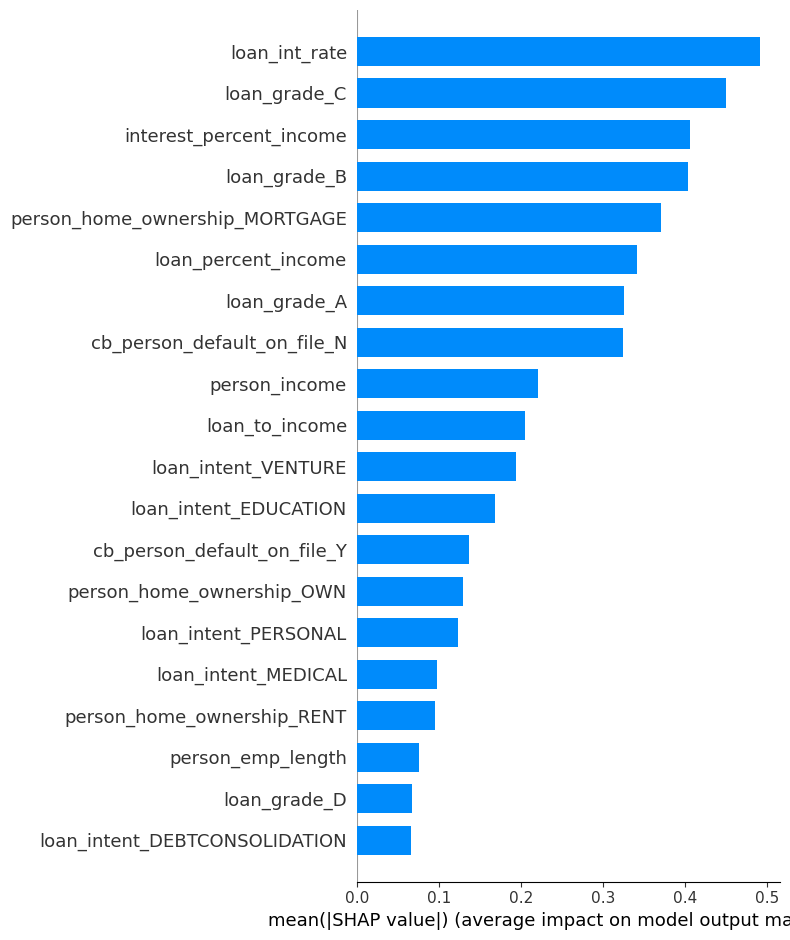

In [42]:
# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

In [43]:
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

,column_name,shap_importance
4,loan_int_rate,0.490995
19,loan_grade_C,0.449364
26,interest_percent_income,0.405383
18,loan_grade_B,0.403172
7,person_home_ownership_MORTGAGE,0.370448
5,loan_percent_income,0.341813
17,loan_grade_A,0.325755
24,cb_person_default_on_file_N,0.323819
1,person_income,0.220603
29,loan_to_income,0.204355


## 7 Predict

In [44]:
# train_df = pd.concat([X, y], axis=1)

In [45]:
# hill_climb_test_preds, _ = climb_hill(
#     train=train_df,
#     oof_pred_df=pd.DataFrame(oof_preds),
#     test_pred_df=pd.DataFrame(test_preds),
#     target="loan_status",
#     objective="maximize",
#     eval_metric=partial(roc_auc_score),
#     negative_weights=True,
#     precision=0.001,
#     plot_hill=True,
#     plot_hist=False,
#     return_oof_preds=True)

In [47]:
submission = pd.DataFrame({
    "id": X_test_index,
    "loan_status": test_preds["XGBoost"]
})

# Save the submission to a CSV file
submission.to_csv('submission.csv', index=False)

## 8 Deployment

### Pickling the model file for deployment

In [48]:
import pickle

In [49]:
pickle.dump(best_xgb_model, open('xgbmodel.pkl', 'wb'))